# Import Libraries & Load the dataset

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import xgboost as xgb

import datasist as ds
from datasist.structdata import detect_outliers

In [2]:
df_initial = pd.read_csv("./housing.csv")
df_initial.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Data Overview

In [3]:
df_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df_initial.describe().round(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.00,20640.00,20640.00,20640.00,20433.00,20640.00,20640.00,20640.00,20640.00
mean,-119.57,35.63,28.64,2635.76,537.87,1425.48,499.54,3.87,206855.82
std,2.00,2.14,12.59,2181.62,421.39,1132.46,382.33,1.90,115395.62
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.80,33.93,18.00,1447.75,296.00,787.00,280.00,2.56,119600.00
50%,-118.49,34.26,29.00,2127.00,435.00,1166.00,409.00,3.53,179700.00
75%,-118.01,37.71,37.00,3148.00,647.00,1725.00,605.00,4.74,264725.00
max,-114.31,41.95,52.00,39320.00,6445.00,35682.00,6082.00,15.00,500001.00


In [5]:
df_initial.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

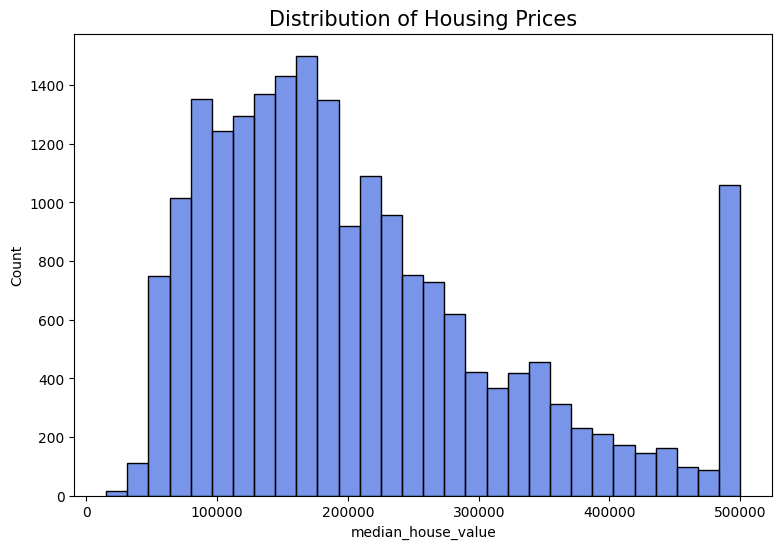

In [6]:
plt.figure(figsize=(9, 6))
sns.histplot(df_initial['median_house_value'], bins=30, color="royalblue", edgecolor="black", alpha=0.7)

plt.title("Distribution of Housing Prices", fontsize=15, color="black")
plt.show()

# Exploratory Data Analysis(EDA)

## Check Missing Values & Duplicates

In [7]:
def resumetable(df_initial):
    print(f'Dataset shape: {df_initial.shape}')
    summary = pd.DataFrame(df_initial.dtypes, columns=['Data Type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'Feature'})
    summary['Missing Values'] = df_initial.isnull().sum().values
    summary['Unique Values'] = df_initial.nunique().values
    
    return summary

resumetable(df_initial)

Dataset shape: (20640, 10)


,Feature,Data Type,Missing Values,Unique Values
0,longitude,float64,0,844
1,latitude,float64,0,862
2,housing_median_age,float64,0,52
3,total_rooms,float64,0,5926
4,total_bedrooms,float64,207,1923
5,population,float64,0,3888
6,households,float64,0,1815
7,median_income,float64,0,12928
8,median_house_value,float64,0,3842
9,ocean_proximity,object,0,5


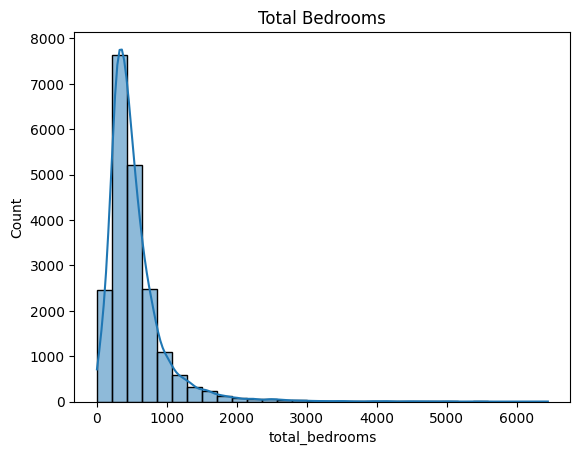

In [8]:
sns.histplot(df_initial["total_bedrooms"], bins=30, kde=True)
plt.title("Total Bedrooms")
plt.show()

The distribution of total_bedrooms is skewed, it's better to replace null values by median.

In [9]:
#not normal distribution - use median to fill NA
df_initial.loc[:, 'total_bedrooms'] = df_initial['total_bedrooms'].fillna(df_initial['total_bedrooms'].median())

In [10]:
df_initial = df_initial.drop_duplicates() #if exists

## Distributions (Skewness & Kurtosis)

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

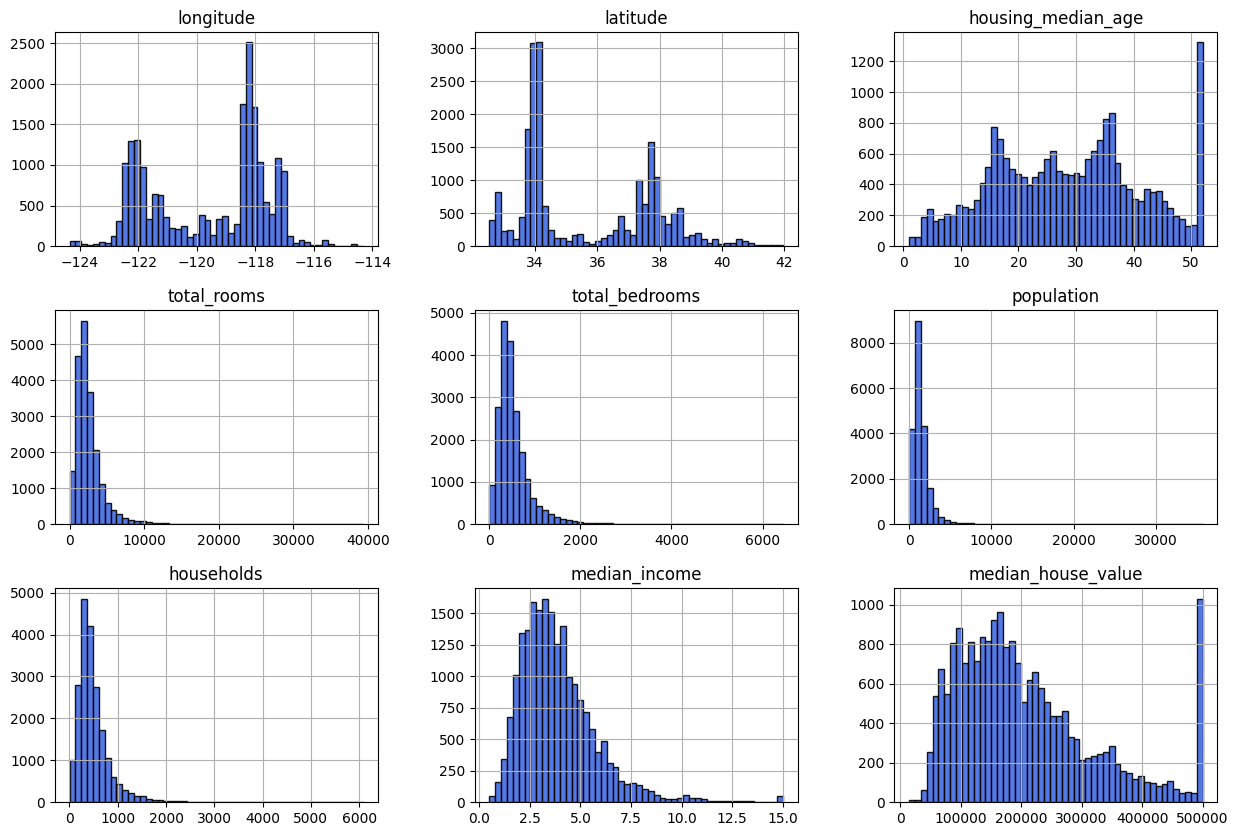

In [11]:
df_initial.hist(bins=50, figsize=(15, 10), color="royalblue", edgecolor="black", alpha=0.9)

House_median_age is one possible feature with such outliers. Also having a lot of local peaks (all are quite gradual) but one really odd peak at the maximum value stands out. It has some slight discontinuity in data.
Feature Median_house_value has an odd peak at its maximum value (around 500k), which could be an outlier.

Skewness > 0: The distribution has a longer right tail (positive skew).
Skewness < 0: The distribution has a longer left tail (negative skew).
Skewness = 0: The distribution is symmetrical (no skew),like a normal distribution.
Kurtosis > 3: The distribution has heavy tails and a sharp peak. There are more extreme values (outliers) than in a normal distribution.
Kurtosis = 3: The distribution is like a normal distribution.
Kurtosis < 3: The distribution has light tails and a flatter peak.

In [12]:
df_int = df_initial.drop(columns=['ocean_proximity'])
skew_kurt_df = pd.DataFrame({
    "Feature": df_int.columns,
    "Skewness": df_int.skew(),
    "Kurtosis": df_int.kurtosis()
})
skew_kurt_df

,Feature,Skewness,Kurtosis
longitude,longitude,-0.297801,-1.330152
latitude,latitude,0.465953,-1.117760
housing_median_age,housing_median_age,0.060331,-0.800629
total_rooms,total_rooms,4.147343,32.630927
total_bedrooms,total_bedrooms,3.481141,22.242758
population,population,4.935858,73.553116
households,households,3.410438,22.057988
median_income,median_income,1.646657,4.952524
median_house_value,median_house_value,0.977763,0.327870


<Figure size 800x500 with 0 Axes>

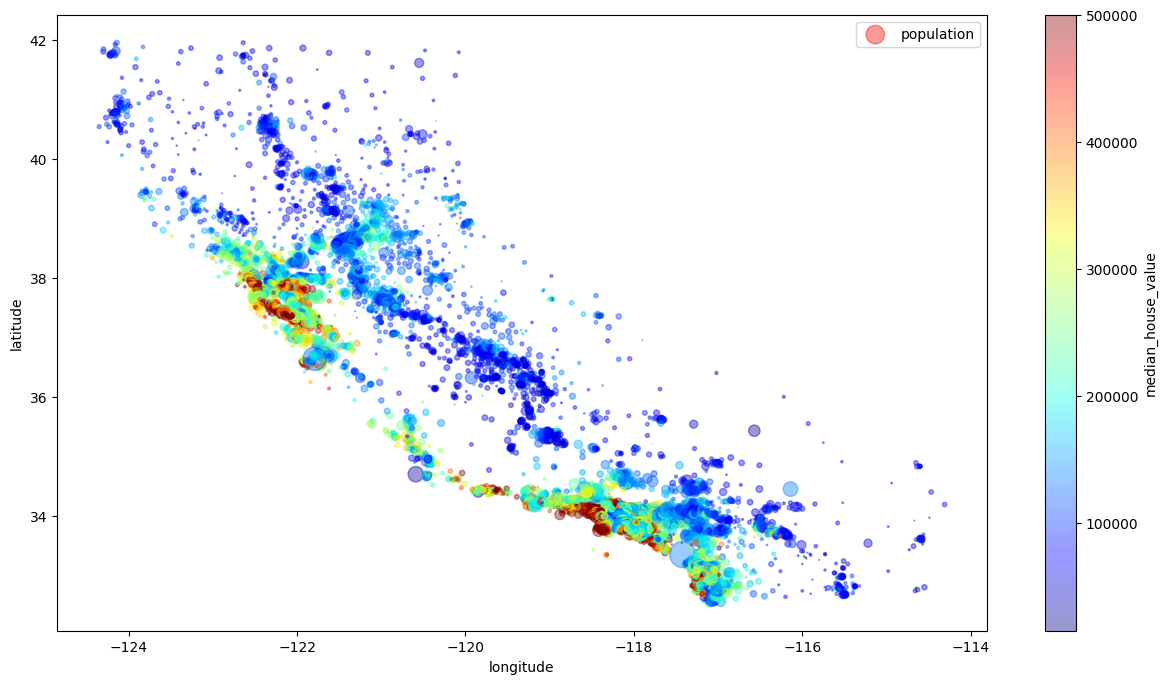

In [13]:
plt.figure(figsize=(8,5));
df_initial.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=df_initial["population"]/100, label="population", figsize=(15,8),
        c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True,
    );
plt.legend();

## Encoding

In [14]:
df_initial["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [15]:
df_initial["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [16]:
# # One-Hot Encoding
# df_encod = pd.get_dummies(df_initial, columns=["ocean_proximity"], drop_first=False).astype(int)
# df_encod.rename(columns={'ocean_proximity_<1H OCEAN': 'ocean_proximity_1H_OCEAN'}, inplace=True)
# df_encod

In [17]:
df_encod = pd.DataFrame(df_initial)
label_encoder = LabelEncoder()

df_encod['ocean_proximity'] = label_encoder.fit_transform(df_encod['ocean_proximity'])
df_encod.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3


## Outliers Detection

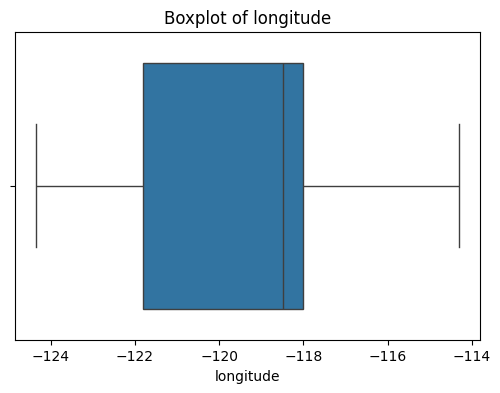

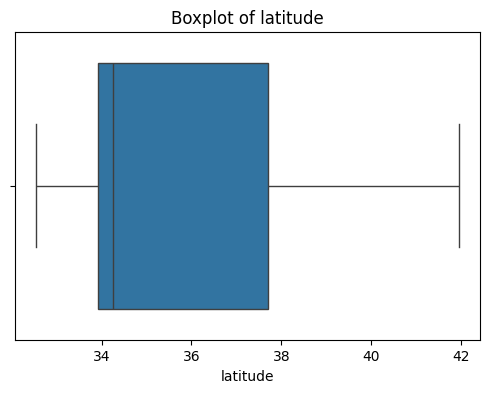

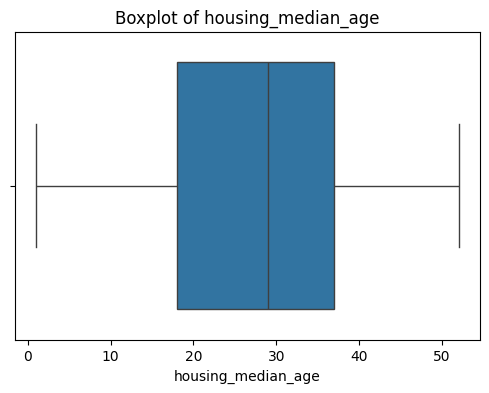

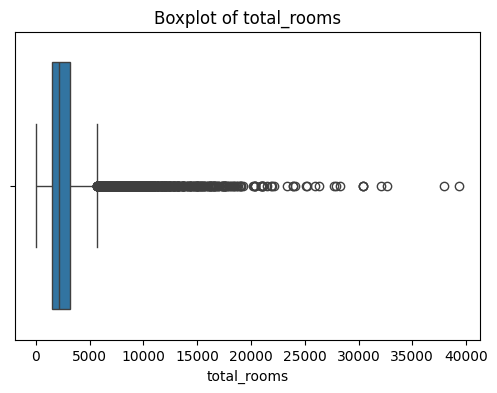

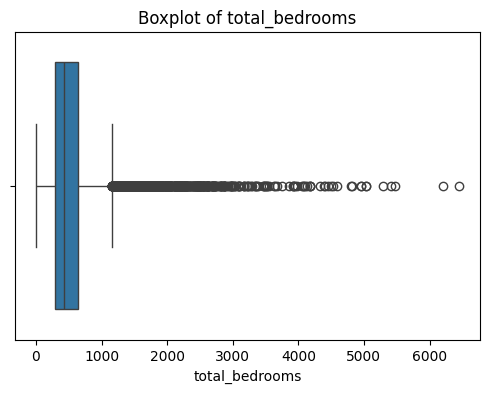

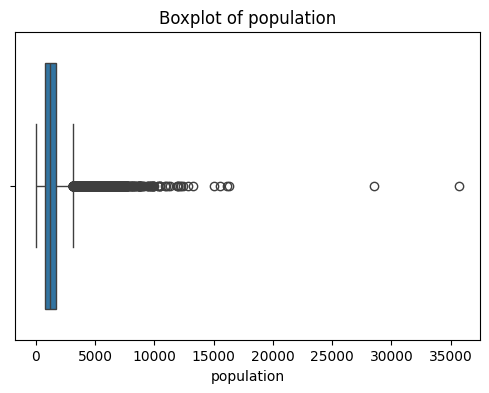

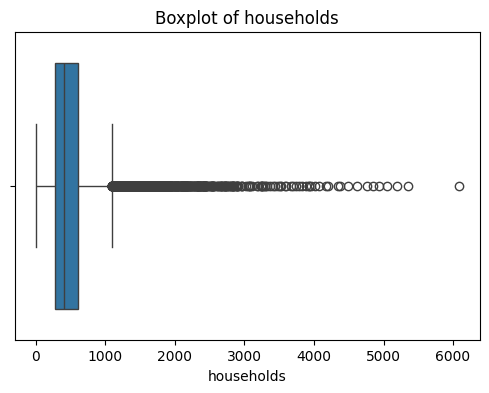

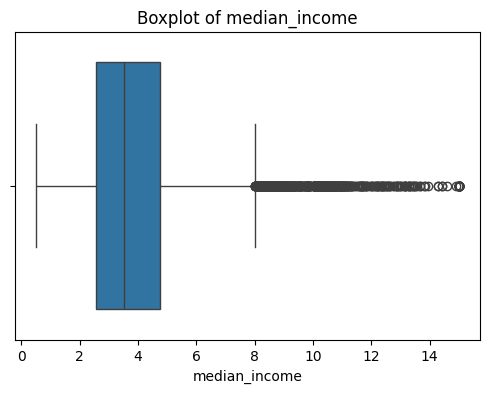

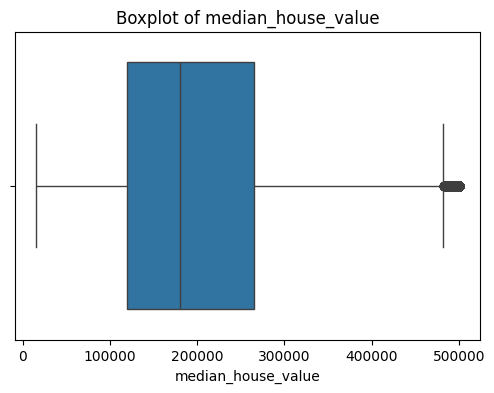

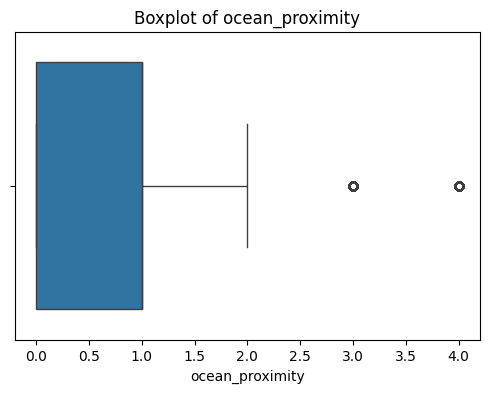

In [18]:
for col in df_encod.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_encod[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [19]:
# Q1 = df_initial['median_house_value'].quantile(0.25)
# Q3 = df_initial['median_house_value'].quantile(0.75)
# IQR = Q3 - Q1

# # Ορισμός των άνω και κάτω ορίων
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Φιλτράρισμα των outliers
# outliers = df_initial[(df_initial['median_house_value'] < lower_bound) | (df_initial['median_house_value'] > upper_bound)]
# print(outliers)

In [20]:
# df_encod['median_house_value'].value_counts().sort_index(ascending=False).head(5)

In [21]:
# df_encod['housing_median_age'].value_counts().sort_index(ascending=False).head(5)

In [22]:
# df_encod = df_encod[df_encod['median_house_value'] != 500001.0]
# df_encod = df_encod[df_encod['housing_median_age'] != 52.0]

In [23]:
outliers = detect_outliers(df_encod,0,[ 'total_rooms', 'total_bedrooms',"population","households","median_income","median_house_value"])

df_encod.drop(outliers,inplace=True)

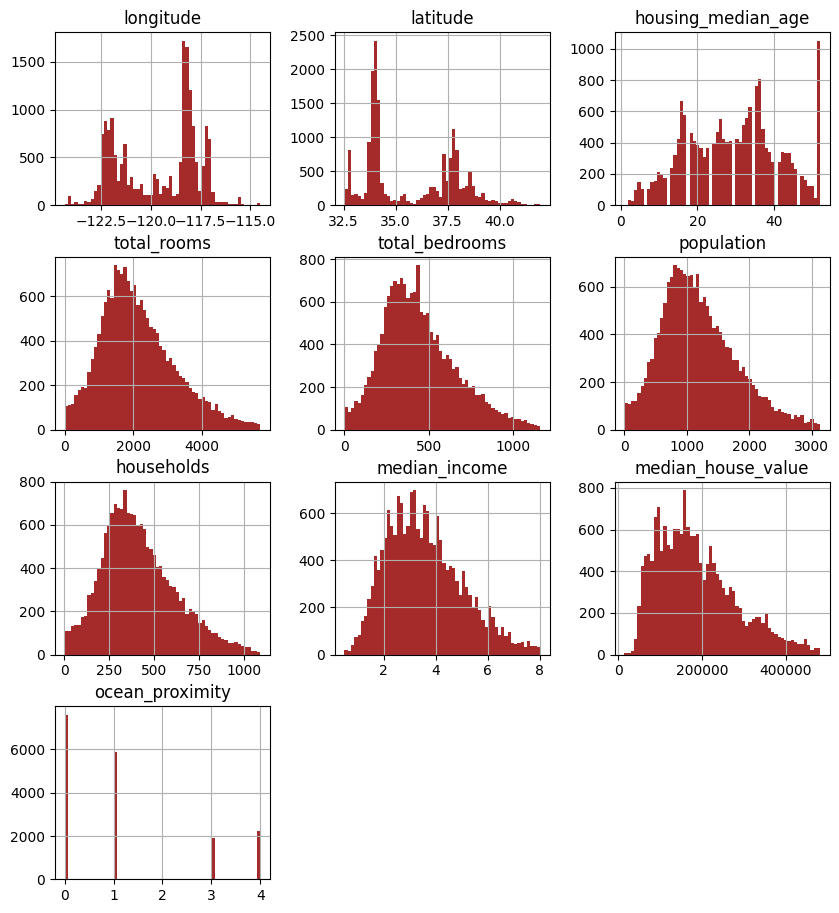

In [24]:
df_encod.hist(bins=60, figsize= (10,11),color='brown');plt.show()

# Correlation Matrix

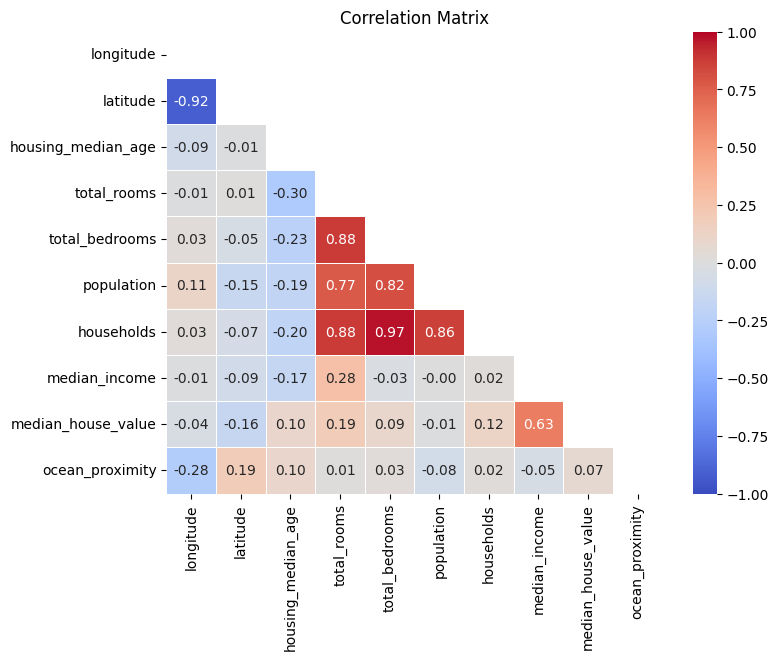

In [25]:
plt.figure(figsize=(8, 6))
corr_matrix = df_encod.corr().round(2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

The target variable median_house_value is very weakly correlated with all features except the median_income.

In [26]:
df_encod.corr(method='pearson').round(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
longitude,1.000,-0.923,-0.085,-0.009,0.030,0.114,0.028,-0.007,-0.044,-0.277
latitude,-0.923,1.000,-0.014,0.007,-0.045,-0.146,-0.067,-0.086,-0.157,0.187
housing_median_age,-0.085,-0.014,1.000,-0.295,-0.225,-0.188,-0.198,-0.167,0.098,0.103
total_rooms,-0.009,0.007,-0.295,1.000,0.881,0.766,0.879,0.280,0.192,0.010
total_bedrooms,0.030,-0.045,-0.225,0.881,1.000,0.816,0.965,-0.028,0.091,0.027
population,0.114,-0.146,-0.188,0.766,0.816,1.000,0.861,-0.000,-0.011,-0.084
households,0.028,-0.067,-0.198,0.879,0.965,0.861,1.000,0.015,0.120,0.018
median_income,-0.007,-0.086,-0.167,0.280,-0.028,-0.000,0.015,1.000,0.629,-0.045
median_house_value,-0.044,-0.157,0.098,0.192,0.091,-0.011,0.120,0.629,1.000,0.068
ocean_proximity,-0.277,0.187,0.103,0.010,0.027,-0.084,0.018,-0.045,0.068,1.000


## Variance Inflation Factor (VIF)

In [27]:
X = df_encod[["longitude","latitude","housing_median_age","total_rooms", "total_bedrooms", "population", "households",
              "median_income", "ocean_proximity"]]

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)
#VIF > 10, multilinearity problem

              Feature         VIF
0           longitude  683.742283
1            latitude  583.536413
2  housing_median_age    7.924773
3         total_rooms   43.517547
4      total_bedrooms   98.331490
5          population   21.340435
6          households  104.180271
7       median_income   13.721475
8     ocean_proximity    1.808212


In [28]:
# # make clusters for locations
# kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
# df_encod["location_cluster"] = kmeans.fit_predict(df_encod[["longitude", "latitude"]])

# df_encod.drop(["longitude", "latitude"], axis=1, inplace=True)

# Feature Engineering

Create new features based "per house" to help the model understand the value of a house.

In [29]:
df_encod["rooms_per_household"] = df_encod["total_rooms"] /df_encod["households"]
df_encod["bedrooms_per_household"] = df_encod["total_bedrooms"] / df_encod["households"]
df_encod["population_per_household"] = df_encod["population"] / df_encod["households"]
df_encod.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3,8.288136,1.073446,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3,5.817352,1.073059,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3,6.281853,1.081081,2.181467


In [30]:
print(df_encod.corr()["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.629247
total_rooms                 0.192084
households                  0.120424
housing_median_age          0.097741
total_bedrooms              0.091409
rooms_per_household         0.088809
ocean_proximity             0.067552
population                 -0.011466
longitude                  -0.043532
bedrooms_per_household     -0.062272
latitude                   -0.157176
population_per_household   -0.188148
Name: median_house_value, dtype: float64


In [31]:
#In combination with the VIF and the correlation table above, thereIn combination with the VIF and the correlation table above, 
#there is an exceptionally small correlation of variables longitude, latitude, population with the target variable, 
#we will proceed with their removal.

df_encod.drop(["latitude", "population"], axis=1, inplace=True)

In [32]:
X1 = df_encod[["longitude","housing_median_age","total_rooms", "total_bedrooms","households","median_income", "rooms_per_household",
               "bedrooms_per_household", "population_per_household", "ocean_proximity"]]

vif_data1 = pd.DataFrame()
vif_data1["Feature"] = X1.columns
vif_data1["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
print(vif_data1)

                    Feature         VIF
0                 longitude   49.173446
1        housing_median_age    7.856977
2               total_rooms   77.252525
3            total_bedrooms  153.329251
4                households  125.742756
5             median_income   13.055891
6       rooms_per_household   70.167701
7    bedrooms_per_household   58.036491
8  population_per_household    9.281155
9           ocean_proximity    1.758778


In [33]:
#remove extra variables due to VIF, we have the information per house
df_encod.drop(["total_rooms", "total_bedrooms"], axis=1, inplace=True)

In [34]:
X2 = df_encod[["longitude","housing_median_age","households", "median_income", "rooms_per_household","bedrooms_per_household", "population_per_household",
               "ocean_proximity"]]

vif_data2 = pd.DataFrame()
vif_data2["Feature"] = X2.columns
vif_data2["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
print(vif_data2)

                    Feature        VIF
0                 longitude  46.716157
1        housing_median_age   7.671612
2                households   5.689999
3             median_income  12.110608
4       rooms_per_household  35.596499
5    bedrooms_per_household  31.157422
6  population_per_household   9.213594
7           ocean_proximity   1.755584


In [35]:
print(df_encod.corr()["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.629247
households                  0.120424
housing_median_age          0.097741
rooms_per_household         0.088809
ocean_proximity             0.067552
longitude                  -0.043532
bedrooms_per_household     -0.062272
population_per_household   -0.188148
Name: median_house_value, dtype: float64


# Linear Regression

In [36]:
X = df_encod.drop(columns=["median_house_value"])
y = df_encod["median_house_value"]

# Split sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [37]:
mae = round(mean_absolute_error(y_test, y_pred),2)
mae

49726.25

Mean Absolute Error (MAE) - shows on average how much the forecasts deviate from the actual values in absolute numbers

In [38]:
mse = round(mean_squared_error(y_test, y_pred),2)
mse

4427472759.17

In [39]:
r2 = round(r2_score(y_test, y_pred),2)
r2

0.52

R² Score (Coefficient of Determination) - the closer to 1.0, the better the explanation of the model

In [40]:
rmse = np.sqrt(mse)

Root Mean Squared Error (RMSE) the square root of the MSE. RMSE provides error in the same unit as the target variable, making it more interpretable than MSE.

## LR with Standard Scaling

Standard Scaling transforms data to a mean of zero (0) and a standard deviation of 1. This is necessary for many algorithms that are affected by different feature scales. 
✔️ Improves model stability and speed.
✔️ Makes regression weights more understandable.
✔️ Prevents features with large values from dominating (e.g. median_income vs housing_median_age).

In [41]:
df_norm = pd.DataFrame(df_encod)

In [42]:
X_norm = df_norm.drop(columns=['median_house_value'])
y_norm = df_norm['median_house_value']

# Split sets (80%-20%)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.3, random_state=123)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm1 = scaler.fit_transform(X_train_norm)
X_test_norm1 = scaler.transform(X_test_norm)

# Train
model_norm = LinearRegression()
model_norm.fit(X_train_norm1, y_train_norm)

# Predictions
y_pred_norm = model_norm.predict(X_test_norm1)

In [43]:
# Evaluation
mae_norm = round(mean_absolute_error(y_test_norm, y_pred_norm),2)
mse_norm = round(mean_squared_error(y_test_norm, y_pred_norm),2)
r2_norm = round(r2_score(y_test_norm, y_pred_norm),2)
rmse_norm = np.sqrt(mse_norm)

print(f"Mean Squared Error (MSE): {mse_norm}")
print(f"Mean Absolute Error (MAE): {mae_norm}")
print(f"R² Score: {r2_norm}")
print(f"Root Mean Squared Error (RMSE): {rmse_norm:.4f}")

Mean Squared Error (MSE): 4307008663.2
Mean Absolute Error (MAE): 50281.69
R² Score: 0.52
Root Mean Squared Error (RMSE): 65627.8040


# Random Forest Regressor

Random Forest Regressor
✅ It is a nonlinear model and can learn complex relationships between variables.
✅ It uses multiple Decision Trees, which improves accuracy and reduces overfitting.
✅ It is robust to outliers and is not affected by multicollinearity.
✅ It can handle missing values ​​better than linear regression.

In [44]:
model_rf = RandomForestRegressor(n_estimators=50, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [45]:
mse_rf = round(mean_squared_error(y_test, y_pred_rf),2)
mae_rf = round(mean_absolute_error(y_test, y_pred_rf),2)
r2_rf = round(r2_score(y_test, y_pred_rf),2)
rmse_rf = np.sqrt(mse_rf)

print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"Mean Absolute Error (MAE): {mae_rf}")
print(f"R² Score: {r2_rf}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")

Mean Squared Error (MSE): 2368566264.47
Mean Absolute Error (MAE): 33209.06
R² Score: 0.74
Root Mean Squared Error (RMSE): 48667.9182


In [46]:
# Perform K-Fold Cross Validation and evaluate using R^2 (coefficient of determination)
cv_scores = cross_val_score(model_rf, X, y, cv=5, scoring='r2')  # 5-fold cross-validation

In [47]:
##Try for different number of estimators, if we have a better result

# from sklearn.model_selection import cross_val_score

# n_estimators_range = [30, 50, 100, 200, 300]
#r2_scores = []

# for n in n_estimators_range:
#     rf = RandomForestRegressor(n_estimators=n, random_state=42)
#     rf.fit(X_train_rf, y_train_rf)
#     y_pred_rf = rf.predict(X_test_rf)
#     r2_rf = r2_score(y_test_rf, y_pred_rf)
#     r2_scores.append(r2_rf) 

# for n, r2 in zip(n_estimators_range, r2_scores):
#     print(f"n_estimators={n}, R²: {r2_rf:.4f}")

# XGBoost

In [48]:
from xgboost import XGBRegressor

XGBR = XGBRegressor(n_estimators=300, max_depth=6, eta=0.1, subsample=0.8, colsample_bytree=0.8)
XGBR.fit(X_train, y_train)
y_pred_xgb = XGBR.predict(X_test)

In [49]:
mse_xgb = round(mean_squared_error(y_test, y_pred_xgb),2)
mae_xgb = round(mean_absolute_error(y_test, y_pred_xgb),2)
r2_xgb = round(r2_score(y_test, y_pred_xgb),2)
rmse_xgb = np.sqrt(mse_xgb)

print(f"Mean Squared Error (MSE): {mse_xgb}")
print(f"Mean Absolute Error (MAE): {mae_xgb}")
print(f"R² Score: {r2_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")

Mean Squared Error (MSE): 2169621665.15
Mean Absolute Error (MAE): 31474.92
R² Score: 0.76
Root Mean Squared Error (RMSE): 46579.20


In [50]:
## Check other values of estimators to take the best result 

# from sklearn.metrics import r2_score

# # Range of n_estimators to test
# n_estimators_range = [30, 50, 100, 200, 300, 500, 1000]
# r2_scores = []

# # Loop over the range of n_estimators
# for n in n_estimators_range:
#     # Initialize the XGBoost Regressor with the current number of estimators
#     xgb_regressor = xgb.XGBRegressor(n_estimators=n, eta=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42)
    
#     # Train the model
#     xgb_regressor.fit(X_train, y_train)
    
#     # Make predictions
#     y_pred_xgb = xgb_regressor.predict(X_test)
    
#     # Calculate R² score
#     r2_xgb = r2_score(y_test, y_pred_xgb)
#     r2_scores.append(r2_xgb)

# # Print the R² scores for each number of estimators
# for n, r2 in zip(n_estimators_range, r2_scores):
#     print(f"n_estimators={n}, R²: {r2:.4f}")


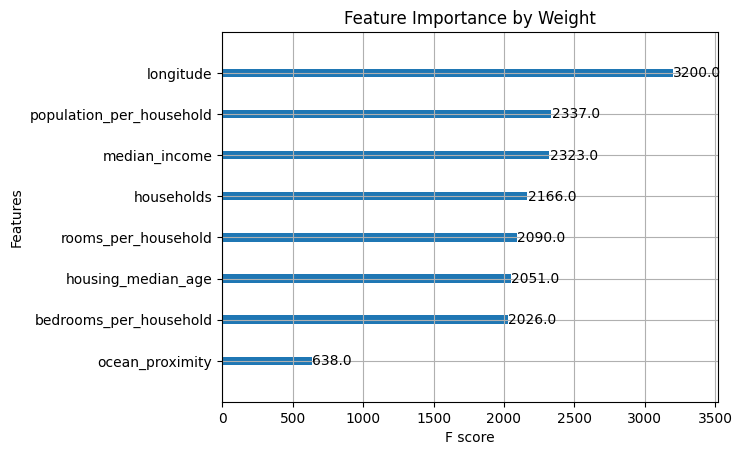

In [51]:
# Plot feature importance
xgb.plot_importance(XGBR, importance_type='weight', max_num_features=10, title="Feature Importance by Weight")
plt.show()

In [52]:
## Try another model, Ridge Regressor

# from sklearn.linear_model import Ridge
# X_rid = df_encod.drop(columns=["median_house_value"])
# y_rid = df_encod["median_house_value"]

# X_train_rid, X_test_rid, y_train_rid, y_test_rid = train_test_split(X_rid, y_rid, test_size=0.2, random_state=42)
# ridge_reg = Ridge(alpha=3, solver="cholesky")
# ridge_reg.fit(X_train_rid, y_train_rid)
 
# y_pred_rid = ridge_reg.predict(X_test_rid)
# mse_rid = round(mean_squared_error(y_test_rid, y_pred_rid),2)
# mae_rid = round(mean_absolute_error(y_test_rid, y_pred_rid),2)
# r2_rid = round(r2_score(y_test_rid, y_pred_rid),2)

# print(f"Mean Squared Error (MSE): {mse_rid}")
# print(f"Mean Absolute Error (MAE): {mae_rid}")
# print(f"R² Score: {r2_rid}")

# Sum Up Evaluation Measures

In [53]:
# Create a summary table of the error metrics
error_metrics = {
    'MAE': [mae, mae_norm, mae_rf, mae_xgb],
    'MSE': [mse, mse_norm, mse_rf, mse_xgb],
    'R2': [r2, r2_norm, r2_rf, r2_xgb],
    'RMSE':[rmse, rmse_norm, rmse_rf, rmse_xgb]
}
error_metrics_df = pd.DataFrame(error_metrics)
print(error_metrics_df)

        MAE           MSE    R2          RMSE
0  49726.25  4.427473e+09  0.52  66539.257278
1  50281.69  4.307009e+09  0.52  65627.804041
2  33209.06  2.368566e+09  0.74  48667.918226
3  31474.92  2.169622e+09  0.76  46579.197773


# Predictions

We have the best score with XGBoost model, so we choose it for our predictions!

In [54]:
y_pred = XGBR.predict(X_test)

print(y_pred)

[ 58188.777 245581.62  204064.12  ...  91468.32  301708.53  175446.34 ]


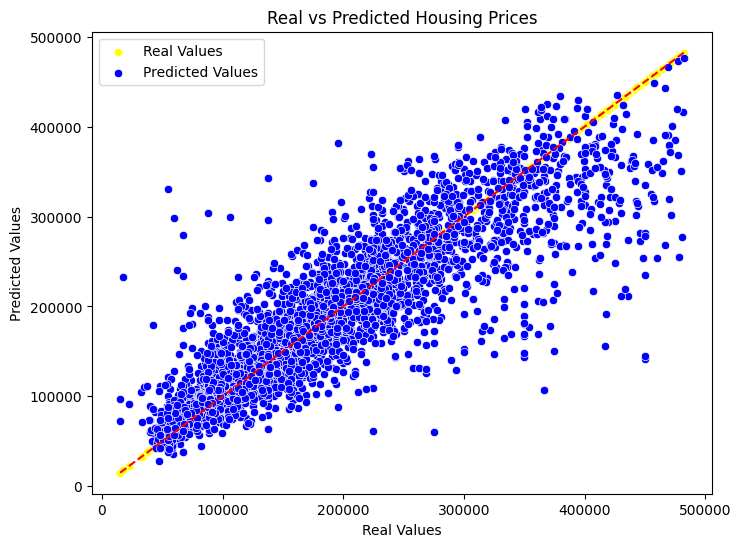

In [55]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test, color='yellow', label='Real Values')
sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Predicted Values')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.title('Real vs Predicted Housing Prices')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')

plt.legend()
plt.show()

# Save Models

In [56]:
import joblib
joblib.dump(model_rf, 'random_forest_model.pkl')
joblib.dump(XGBR, 'xgboost_model.pkl')
joblib.dump(model_norm, 'linear_regression_standard_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')